## Configuration

In [1]:
from src.mcusum import MCUSUMDetector
from src.mcusum import plot_mcusum_diagnostics
from src.autoencoder import AutoencoderDetector
from src.autoencoder_enhanced import AutoencoderDetectorEnhanced
from src.base_ewma import BaseEWMA
from src.standard_mewma import StandardMEWMA


import matplotlib.pyplot as plt
import numpy as np
from typing import List,Dict,Any
import pandas as pd


from numpy.typing import NDArray
from typing import Tuple

In [2]:
import pyreadr
from sklearn.preprocessing import StandardScaler

TARGET_VARIABLE_COLUMN_NAME = "faultNumber"
SIMULATION_RUN_COLUMN_NAME = "simulationRun"
COLUMNS_TO_REMOVE = [TARGET_VARIABLE_COLUMN_NAME, SIMULATION_RUN_COLUMN_NAME, "sample"]



fault_free_training_dict = pyreadr.read_r("data/TEP_FaultFree_Training.RData")
fault_free_testing_dict = pyreadr.read_r("data/TEP_FaultFree_Testing.RData")

faulty_training_dict = pyreadr.read_r("data/TEP_Faulty_Training.RData")
faulty_testing_dict = pyreadr.read_r("data/TEP_Faulty_Testing.RData")

DF_FF_TRAINING_RAW = fault_free_training_dict["fault_free_training"]
DF_FF_TEST_RAW = fault_free_testing_dict["fault_free_testing"]

DF_F_TRAINING_RAW = faulty_training_dict["faulty_training"]
DF_F_TEST_RAW = faulty_testing_dict["faulty_testing"]

In [3]:
# In-control X training data
scaler_incontrol = StandardScaler()
X_INCONTROL_TRAIN_FULL_DF = DF_FF_TRAINING_RAW.drop(columns=COLUMNS_TO_REMOVE, axis=1)

scaler_incontrol.fit(X_INCONTROL_TRAIN_FULL_DF)
X_INCONTROL_TRAIN_FULL_SCALED = scaler_incontrol.transform(X_INCONTROL_TRAIN_FULL_DF)
print("In-control training data shape:", X_INCONTROL_TRAIN_FULL_SCALED.shape)

In-control training data shape: (250000, 52)


In [4]:
simulation_run = 1
fault_number = 2

DF_FF_TRAINING = DF_FF_TRAINING_RAW.query("simulationRun == @simulation_run")
DF_FF_TEST = DF_FF_TEST_RAW.query("simulationRun == @simulation_run")

DF_F_TRAINING = DF_F_TRAINING_RAW.query("faultNumber == @fault_number and simulationRun == @simulation_run")
DF_F_TEST = DF_F_TEST_RAW.query("faultNumber == @fault_number and simulationRun == @simulation_run")


# In-control test data
#scaler_incontrol = StandardScaler()
X_INCONTROL_TRAIN_REDUCED_DF = DF_FF_TRAINING.drop(columns=COLUMNS_TO_REMOVE, axis=1)
X_INCONTROL_TEST_REDUCED_DF = DF_FF_TEST.drop(columns=COLUMNS_TO_REMOVE, axis=1)

scaler_incontrol.fit(X_INCONTROL_TRAIN_REDUCED_DF)
X_INCONTROL_TRAIN_REDUCED_SCALED = scaler_incontrol.transform(X_INCONTROL_TRAIN_REDUCED_DF)
X_INCONTROL_TEST_REDUCED_SCALED = scaler_incontrol.transform(X_INCONTROL_TEST_REDUCED_DF)

# Out-of-control test data
X_OUT_OF_CONTROL_TEST_REDUCED_DF = DF_F_TEST.drop(columns=COLUMNS_TO_REMOVE, axis=1)
X_OUT_OF_CONTROL_TRAIN_REDUCED_DF = DF_F_TRAINING.drop(columns=COLUMNS_TO_REMOVE, axis=1)

X_OUT_OF_CONTROL_TEST_REDUCED_SCALED = scaler_incontrol.transform(X_OUT_OF_CONTROL_TEST_REDUCED_DF)
X_OUT_OF_CONTROL_TRAIN_REDUCED_SCALED = scaler_incontrol.transform(X_OUT_OF_CONTROL_TRAIN_REDUCED_DF)

print("In-control training data shape:", X_INCONTROL_TRAIN_REDUCED_SCALED.shape)
print("In-control test data shape:", X_INCONTROL_TEST_REDUCED_SCALED.shape)
print("Out-of-control training data shape:", X_OUT_OF_CONTROL_TRAIN_REDUCED_SCALED.shape)
print("Out-of-control test data shape:", X_OUT_OF_CONTROL_TEST_REDUCED_SCALED.shape)

In-control training data shape: (500, 52)
In-control test data shape: (960, 52)
Out-of-control training data shape: (500, 52)
Out-of-control test data shape: (960, 52)


## MCUSUM 


In [5]:
# Import MCUSUM detector from extracted module


mcusum = None  # Global MCUSUM instance to be initialized later

def apply_mcusum(X_INCONTROL_TEST, X_OUT_OF_CONTROL_TEST, verbose: bool = True) -> Tuple[NDArray[np.int_], NDArray[np.int_]]:
    
    stats_normal, flags_normal = mcusum.predict(X_INCONTROL_TEST)
    stats_anomaly, flags_anomaly = mcusum.predict(X_OUT_OF_CONTROL_TEST)
    
    # Create diagnostic plots
    if verbose:
        plot_mcusum_diagnostics(stats_normal, stats_anomaly, mcusum.h, "Tennessee_Eastman") # type: ignore

    # Convert boolean flags to 0 (normal) and 1 (anomaly)
    return flags_normal.astype(int), flags_anomaly.astype(int)


def mcusum_predict(x_scaled):

    stats_normal, y_pred = mcusum.predict(x_scaled)

    return y_pred.astype(int)




6.402518750870242
control limit h: None


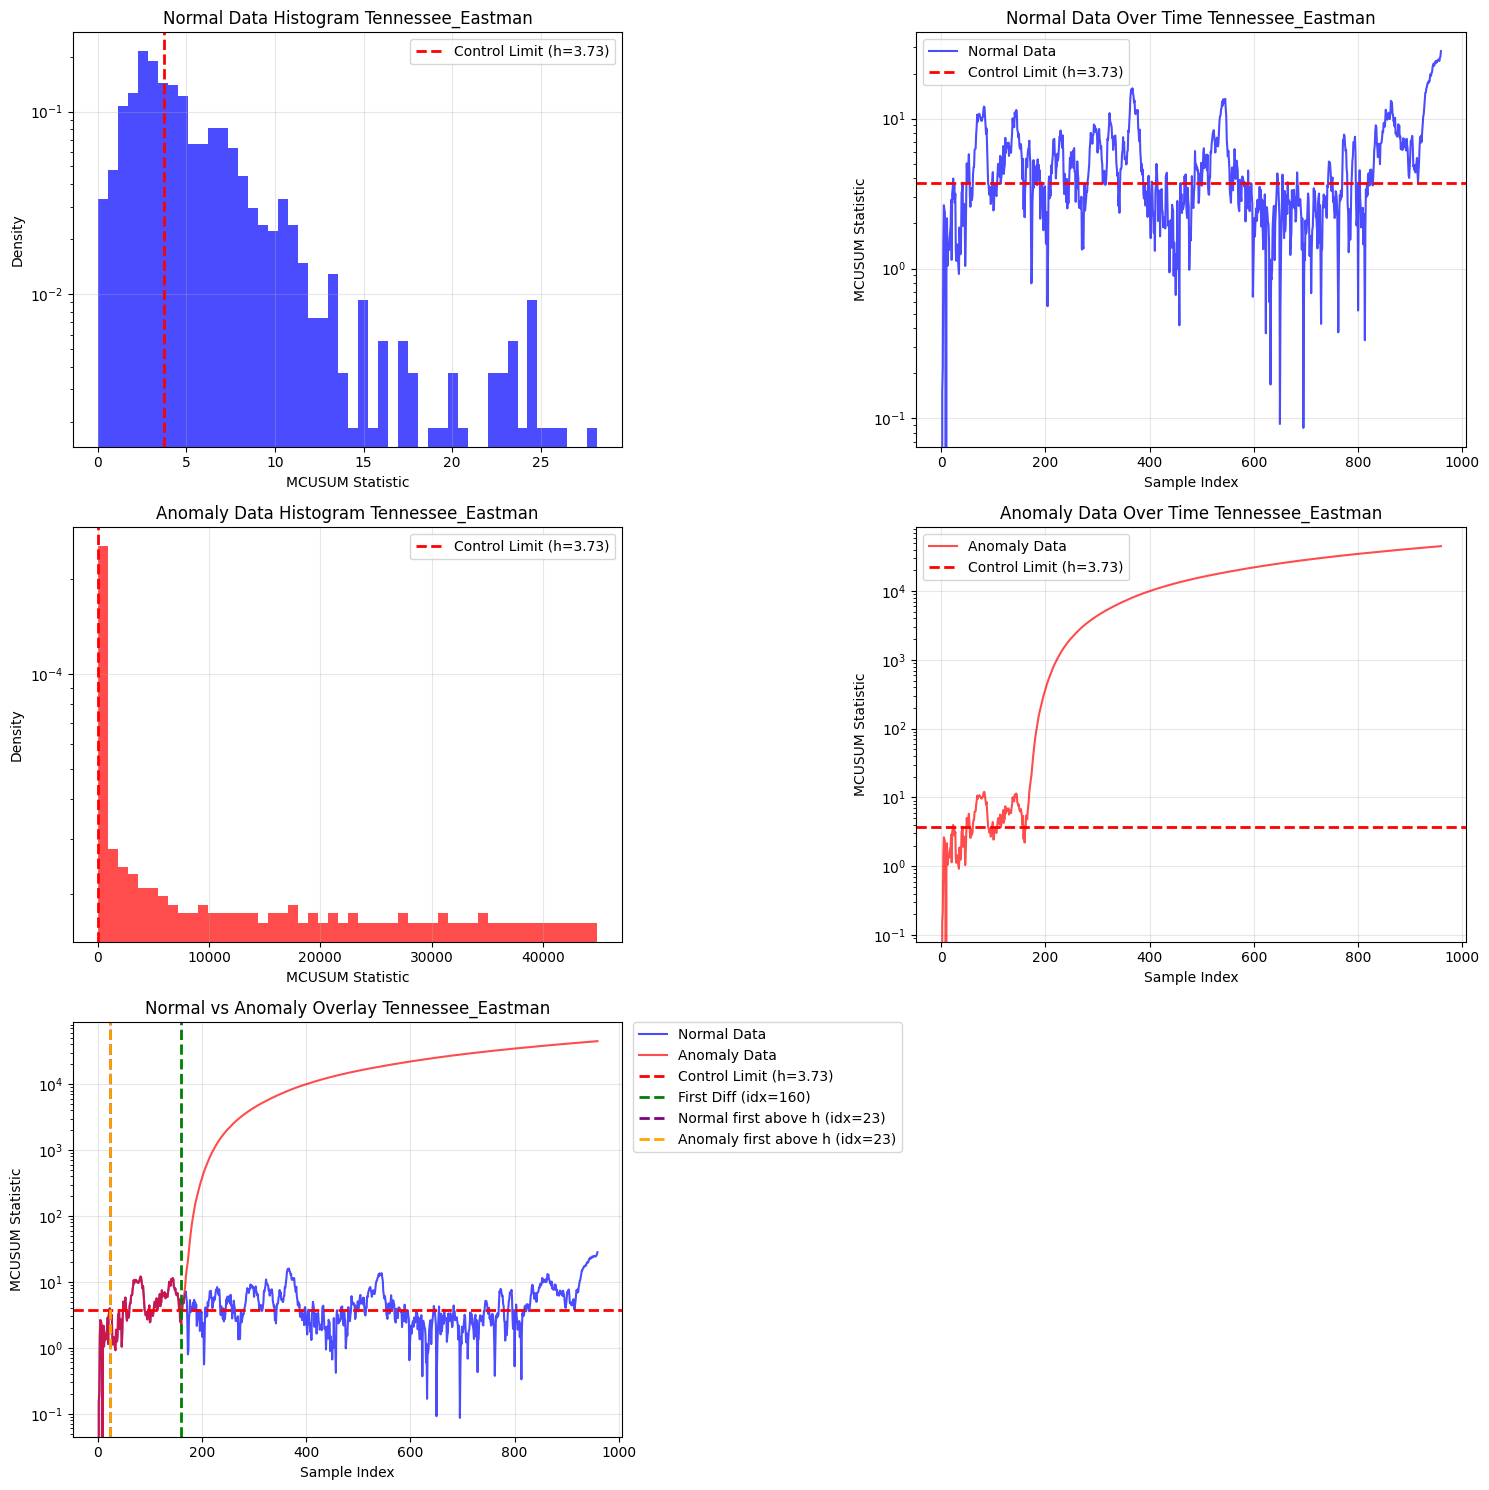

ARL0 (In-control): 23
ARL1 (Out-of-control): 23
593


In [6]:

n_features = X_INCONTROL_TRAIN_FULL_SCALED.shape[1]
delta = np.ones(n_features) * 0.1
mu_0, sigma = MCUSUMDetector._estimate_incontrol_parameters(X_INCONTROL_TRAIN_FULL_SCALED)
k = MCUSUMDetector.compute_reference_value_k(delta, sigma)
print(k)
mcusum = MCUSUMDetector(k=k ) # type: ignore
mcusum.fit(X_INCONTROL_TRAIN_FULL_SCALED)

flags_normal, flags_anomaly = apply_mcusum(
	X_INCONTROL_TEST_REDUCED_SCALED,
	X_OUT_OF_CONTROL_TEST_REDUCED_SCALED
)

arl0 = np.argmax(flags_normal == 1) if np.any(flags_normal == 1) else None
arl1 = np.argmax(flags_anomaly == 1) if np.any(flags_anomaly == 1) else None

print("ARL0 (In-control):", arl0)
print("ARL1 (Out-of-control):", arl1)

n = min(len(flags_normal), len(flags_anomaly))
print(np.sum(flags_normal[:n] == flags_anomaly[:n]))


**As we see in the plot "Normal vs Anomaly Overlay" the fault injection start at the point 160, so we need to cut out the data before this point for both in-control and out-of-control test sets.**

6.402518750870242
control limit h: 3


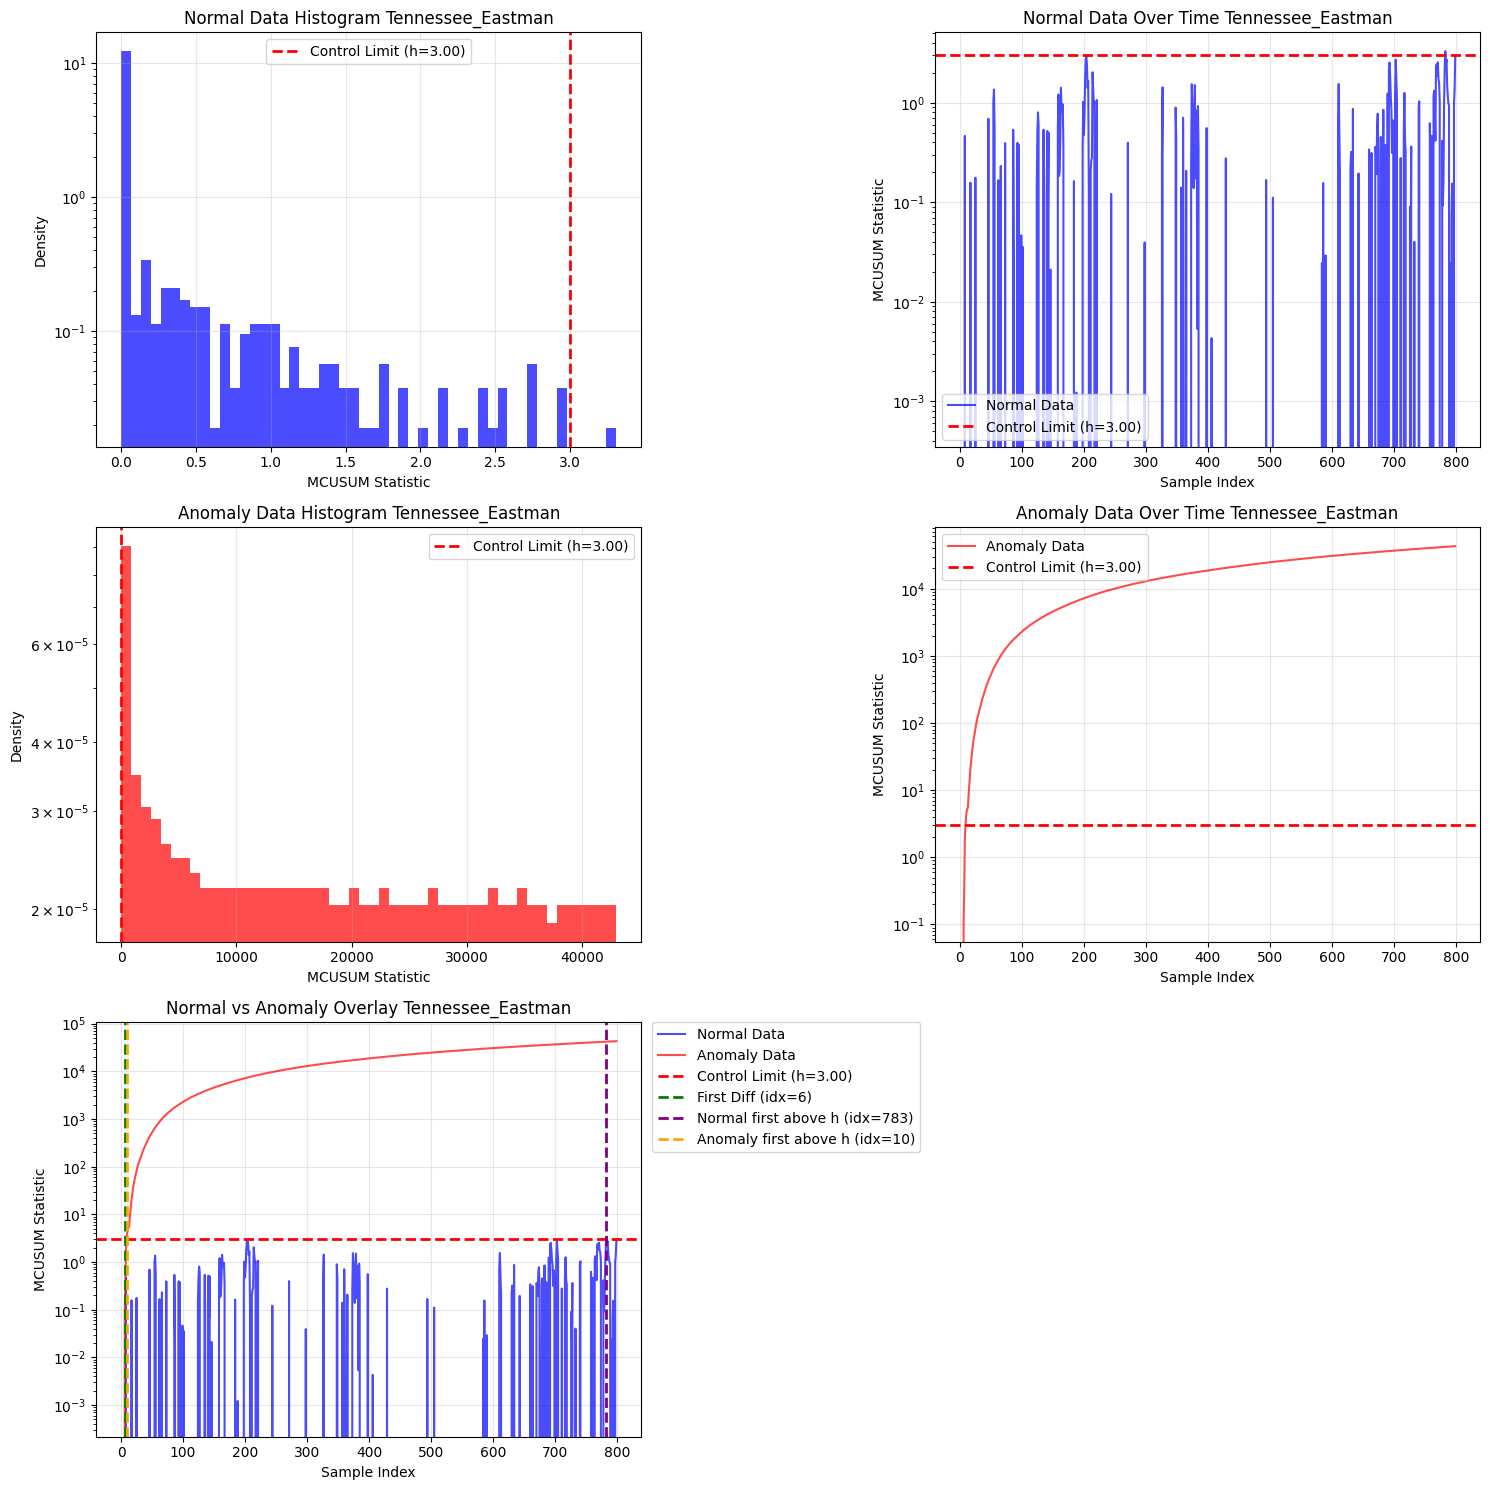

In-control test data shape: (960, 52)
Cut In-control test data shape: (800, 52)
ARL0 (In-control): 783
ARL1 (Out-of-control): 10
11


In [7]:

n_features = X_INCONTROL_TRAIN_FULL_SCALED.shape[1]
delta = np.ones(n_features) * 0.1
mu_0, sigma = MCUSUMDetector._estimate_incontrol_parameters(X_INCONTROL_TRAIN_FULL_SCALED)
k = MCUSUMDetector.compute_reference_value_k(delta, sigma)
print(k)

mcusum = MCUSUMDetector(k=9, h=3) # type: ignore
mcusum.fit(X_INCONTROL_TRAIN_FULL_SCALED)

fault_injection_point = 160
X_INCONTROL_TEST_REDUCED_SCALED_CUT = X_INCONTROL_TEST_REDUCED_SCALED[fault_injection_point:]
X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT = X_OUT_OF_CONTROL_TEST_REDUCED_SCALED[fault_injection_point:]

flags_normal, flags_anomaly = apply_mcusum(
	X_INCONTROL_TEST_REDUCED_SCALED_CUT,
	X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT
)

arl0 = np.argmax(flags_normal == 1) if np.any(flags_normal == 1) else None
arl1 = np.argmax(flags_anomaly == 1) if np.any(flags_anomaly == 1) else None

print("In-control test data shape:", X_INCONTROL_TEST_REDUCED_SCALED.shape)
print("Cut In-control test data shape:", X_INCONTROL_TEST_REDUCED_SCALED_CUT.shape)

print("ARL0 (In-control):", arl0)
print("ARL1 (Out-of-control):", arl1)

n = min(len(flags_normal), len(flags_anomaly))
print(np.sum(flags_normal[:n] == flags_anomaly[:n]))


### Finding optimal values

control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
control limit h: 2.8
Best k: 9.317241379310344, ARL0: 800, ARL1: 10
control limit h: 2.8


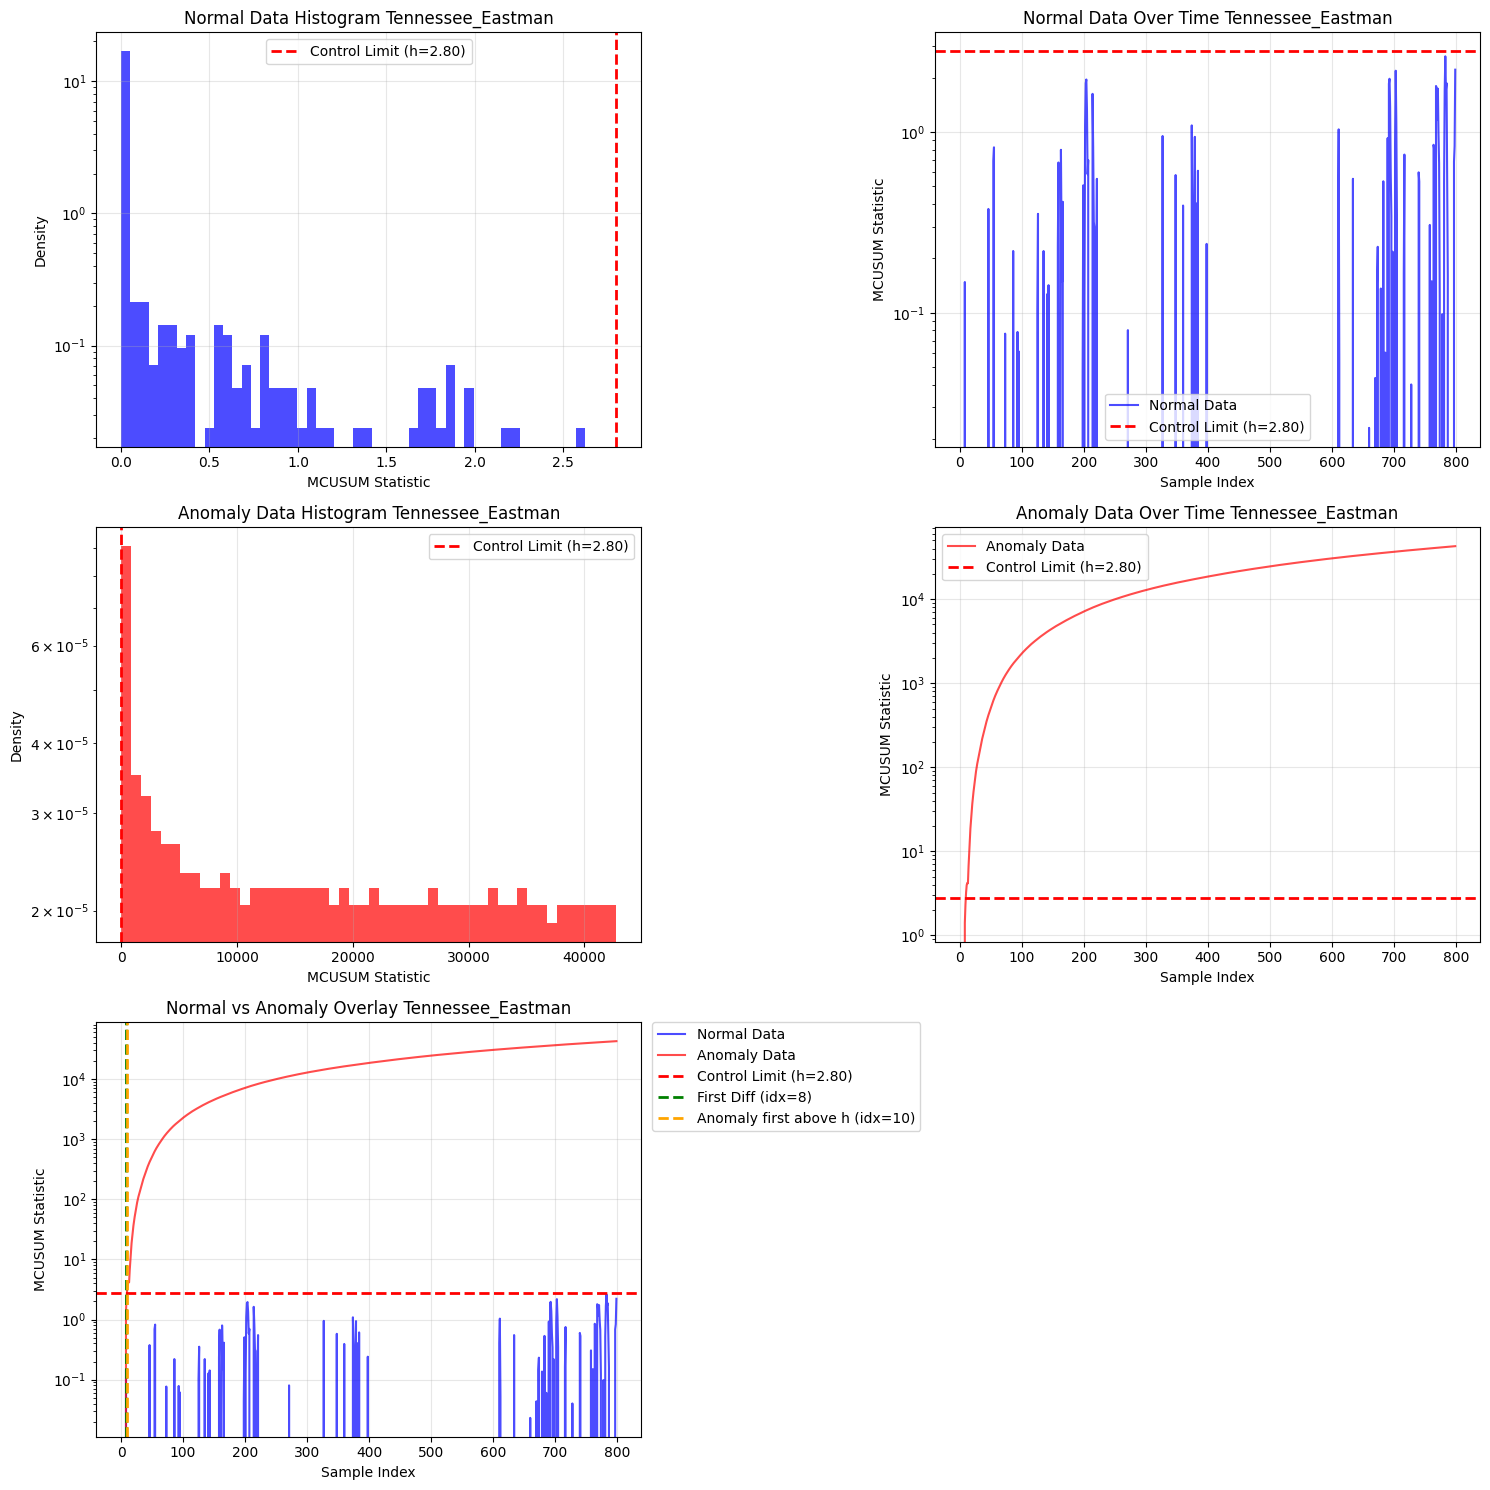

Final ARL0 (In-control): None
Final ARL1 (Out-of-control): 10


In [8]:
best_k = None
best_arl0 = -np.inf
best_arl1 = np.inf

k_values = np.linspace(0.1, 10, 30)  # Adjust range and steps as needed

for k_test in k_values:
    mcusum = MCUSUMDetector(k=k_test, h=2.8)
    mcusum.fit(X_INCONTROL_TRAIN_FULL_SCALED)
    flags_normal, flags_anomaly = apply_mcusum(
        X_INCONTROL_TEST_REDUCED_SCALED_CUT,
        X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT,
        verbose=False
    )
    arl0 = np.argmax(flags_normal == 1) if np.any(flags_normal == 1) else len(flags_normal)
    arl1 = np.argmax(flags_anomaly == 1) if np.any(flags_anomaly == 1) else len(flags_anomaly)
    
    # Prefer higher ARL0, then lower ARL1
    if (arl0 > best_arl0) or (arl0 == best_arl0 and arl1 < best_arl1):
        best_k = k_test
        best_arl0 = arl0
        best_arl1 = arl1

print(f"Best k: {best_k}, ARL0: {best_arl0}, ARL1: {best_arl1}")

# Refit with best k and show results
mcusum = MCUSUMDetector(k=best_k, h=2.8)
mcusum.fit(X_INCONTROL_TRAIN_FULL_SCALED)
flags_normal, flags_anomaly = apply_mcusum(
    X_INCONTROL_TEST_REDUCED_SCALED_CUT,
    X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT
)
arl0 = np.argmax(flags_normal == 1) if np.any(flags_normal == 1) else None
arl1 = np.argmax(flags_anomaly == 1) if np.any(flags_anomaly == 1) else None

print("Final ARL0 (In-control):", arl0)
print("Final ARL1 (Out-of-control):", arl1)


control limit h: 1.0
control limit h: 1.3103448275862069
control limit h: 1.6206896551724137
control limit h: 1.9310344827586208
control limit h: 2.2413793103448274
control limit h: 2.5517241379310347
control limit h: 2.8620689655172415
control limit h: 3.1724137931034484
control limit h: 3.4827586206896552
control limit h: 3.793103448275862
control limit h: 4.103448275862069
control limit h: 4.413793103448276
control limit h: 4.724137931034483
control limit h: 5.0344827586206895
control limit h: 5.344827586206897
control limit h: 5.655172413793103
control limit h: 5.9655172413793105
control limit h: 6.275862068965518
control limit h: 6.586206896551724
control limit h: 6.8965517241379315
control limit h: 7.206896551724138
control limit h: 7.517241379310345
control limit h: 7.827586206896552
control limit h: 8.137931034482758
control limit h: 8.448275862068966
control limit h: 8.758620689655173
control limit h: 9.068965517241379
control limit h: 9.379310344827587
control limit h: 9.6896

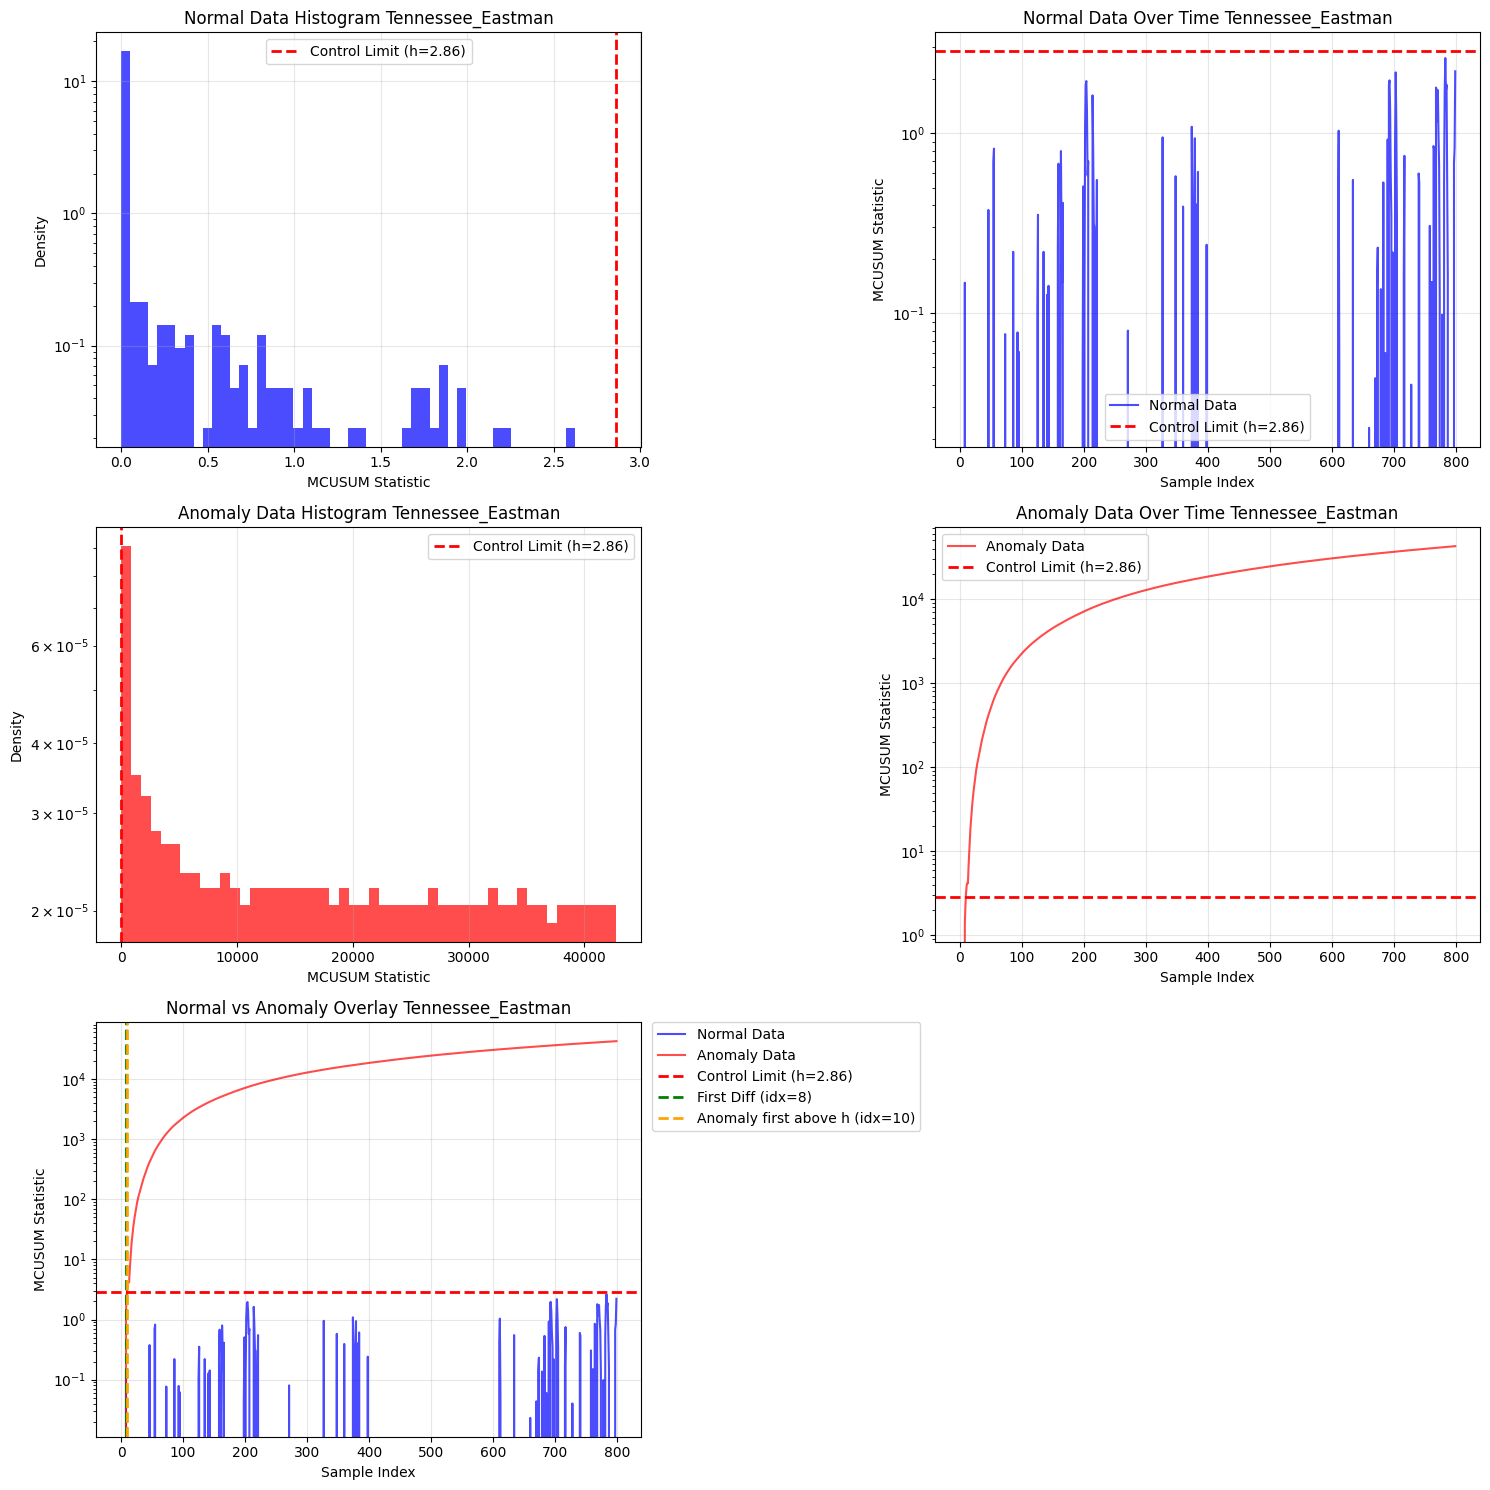

Final ARL0 (In-control): None
Final ARL1 (Out-of-control): 10


In [9]:
best_h = None
best_arl0 = -np.inf
best_arl1 = np.inf

# Fix k to a reasonable value, e.g., from previous best_k or a constant
fixed_k = best_k  # or set to a specific value, e.g., fixed_k = 6.4

h_values = np.linspace(1.0, 10.0, 30)  # Adjust range and steps as needed

for h_test in h_values:
    mcusum = MCUSUMDetector(k=fixed_k, h=h_test)
    mcusum.fit(X_INCONTROL_TRAIN_FULL_SCALED)
    flags_normal, flags_anomaly = apply_mcusum(
        X_INCONTROL_TEST_REDUCED_SCALED_CUT,
        X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT,
        verbose=False
    )
    arl0 = np.argmax(flags_normal == 1) if np.any(flags_normal == 1) else len(flags_normal)
    arl1 = np.argmax(flags_anomaly == 1) if np.any(flags_anomaly == 1) else len(flags_anomaly)
    
    # Prefer higher ARL0, then lower ARL1
    if (arl0 > best_arl0) or (arl0 == best_arl0 and arl1 < best_arl1):
        best_h = h_test
        best_arl0 = arl0
        best_arl1 = arl1

print(f"Best h: {best_h}, ARL0: {best_arl0}, ARL1: {best_arl1}")

# Refit with best h and show results
mcusum = MCUSUMDetector(k=fixed_k, h=best_h)
mcusum.fit(X_INCONTROL_TRAIN_FULL_SCALED)
flags_normal, flags_anomaly = apply_mcusum(
    X_INCONTROL_TEST_REDUCED_SCALED_CUT,
    X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT
)
arl0 = np.argmax(flags_normal == 1) if np.any(flags_normal == 1) else None
arl1 = np.argmax(flags_anomaly == 1) if np.any(flags_anomaly == 1) else None

print("Final ARL0 (In-control):", arl0)
print("Final ARL1 (Out-of-control):", arl1)


In [10]:
n = min(len(flags_normal), len(flags_anomaly))
print(np.sum(flags_normal[:n] == flags_anomaly[:n]))

10


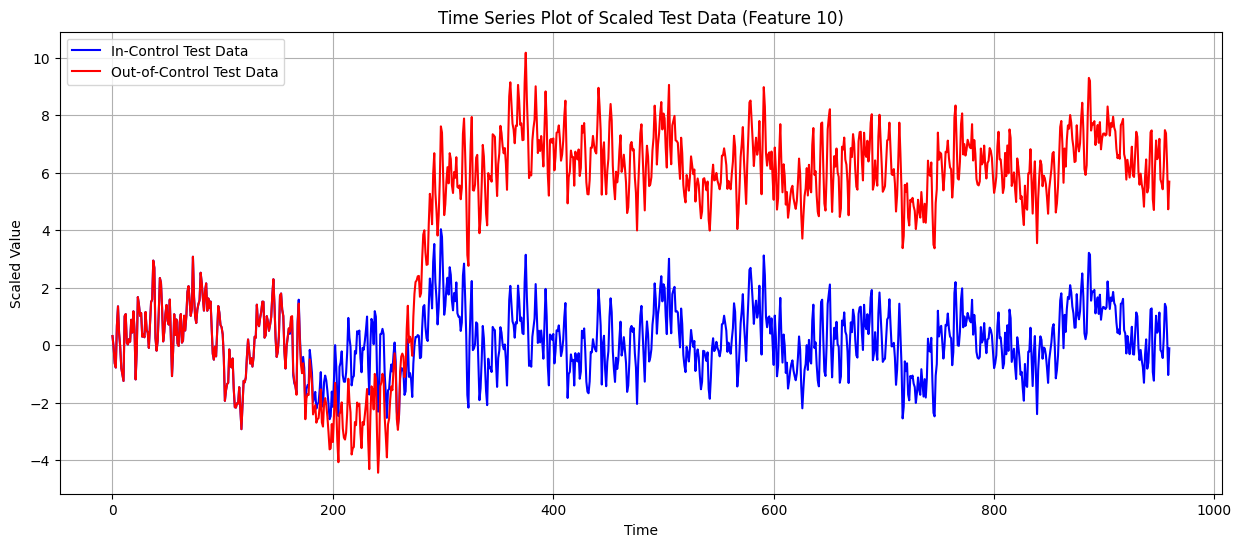

In [11]:
# Choose the feature index to plot (0-based)
feature_idx = 10  # Change this to select a different feature

plt.figure(figsize=(15, 6))
plt.plot(X_INCONTROL_TEST_REDUCED_SCALED[:, feature_idx], label='In-Control Test Data', color='blue')
plt.plot(X_OUT_OF_CONTROL_TEST_REDUCED_SCALED[:, feature_idx], label='Out-of-Control Test Data', color='red')
plt.title(f'Time Series Plot of Scaled Test Data (Feature {feature_idx})')
plt.xlabel('Time')
plt.ylabel('Scaled Value')
plt.legend()
plt.grid()
plt.show()

## Autoencoder

In [ ]:
# autoencoder_detector = AutoencoderDetector()
# autoencoder_detector.fit(X_INCONTROL_TRAIN_FULL_SCALED)

# autoencoder_predictions_anomaly = autoencoder_detector.predict(X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT)
# autoencoder_predictions_normal = autoencoder_detector.predict(X_INCONTROL_TEST_REDUCED_SCALED_CUT)

# arl0 = np.argmax(autoencoder_predictions_normal == 1) if np.any(flags_normal == 1) else None
# arl1 = np.argmax(autoencoder_predictions_anomaly == 1) if np.any(flags_anomaly == 1) else None

# print("ARL0 (In-control):", arl0)
# print("ARL1 (Out-of-control):", arl1)

# autoencoder_detector_enhanced = AutoencoderDetectorEnhanced()
# autoencoder_detector_enhanced.fit(X_INCONTROL_TRAIN_FULL_SCALED)


# autoencoder_predictions_anomaly = autoencoder_detector_enhanced.predict(X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT)
# autoencoder_predictions_normal = autoencoder_detector_enhanced.predict(X_INCONTROL_TEST_REDUCED_SCALED_CUT)

# arl0 = np.argmax(autoencoder_predictions_normal == 1) if np.any(flags_normal == 1) else None
# arl1 = np.argmax(autoencoder_predictions_anomaly == 1) if np.any(flags_anomaly == 1) else None

# print("ARL0 (In-control):", arl0)
# print("ARL1 (Out-of-control):", arl1)

KeyboardInterrupt: 

## EWMA

In [ ]:
# mewma = StandardMEWMA()
# mewma.fit(X_INCONTROL_TRAIN_FULL_SCALED)
# mewma_predictions_normal = mewma.predict(X_INCONTROL_TEST_REDUCED_SCALED_CUT)
# mewma_predictions_anomaly = mewma.predict(X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT)

# arl0 = np.argmax(mewma_predictions_normal == 1) if np.any(flags_normal == 1) else None
# arl1 = np.argmax(mewma_predictions_anomaly == 1) if np.any(flags_anomaly == 1) else None

# print("ARL0 (In-control):", arl0)
# print("ARL1 (Out-of-control):", arl1)

ARL0 (In-control): None
ARL1 (Out-of-control): 8


## DNN-CUSUM (Deep Neural Network-based Adaptive CUSUM)


In [13]:
# Import DNN-CUSUM detector and visualizer
import importlib
import src.dnn_cusum
import src.dnn_cusum_viz

# Reload modules to pick up the NaN fix
importlib.reload(src.dnn_cusum)
importlib.reload(src.dnn_cusum_viz)

# Import the classes
from src.dnn_cusum import DNNCUSUMDetector
from src.dnn_cusum_viz import DNNCUSUMVisualizer

print("✓ Modules reloaded with NaN fix")

✓ Modules reloaded with NaN fix


In [24]:
# Initialize DNN-CUSUM detector
print("Initializing DNN-CUSUM detector...")
dnn_cusum = DNNCUSUMDetector(
    window_size=50,
    model_dir='models/'
)

dnn_cusum.fit(
    X_INCONTROL_TRAIN_FULL_SCALED,  # ← Use FULL dataset
    X_OUT_OF_CONTROL_TRAIN_REDUCED_SCALED,
    force_retrain=False,
    grid_search=False
)
print("\n" + "="*60)
print("Training complete! Model saved.")
print("="*60)

Initializing DNN-CUSUM detector...

RETRAINING: NaN bug in autocorrelation has been fixed

Training New DNN-CUSUM Model
Data dimensions: 52
Generating training data from in-control samples...
Generating training data from out-of-control samples...

Generated 250400 training samples
Feature dimension: 312
k range: [0.16, 0.80]
h range: [3.27, 6.33]

Training final model with best configuration...
Epoch 1/50
6260/6260 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - h_output_loss: 0.6611 - h_output_mae: 0.6025 - k_output_loss: 0.0069 - k_output_mae: 0.0236 - loss: 0.6681 - val_h_output_loss: 0.0777 - val_h_output_mae: 0.1169 - val_k_output_loss: 0.0035 - val_k_output_mae: 0.0075 - val_loss: 0.0812 - learning_rate: 0.0010
Epoch 2/50
6260/6260 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - h_output_loss: 0.1112 - h_output_mae: 0.2467 - k_output_loss: 7.8405e-06 - k_output_mae: 0.0022 - loss: 0.1113 - val_h_output_loss: 0.0761 - val_h_output_mae: 0.0338 - val_k_output_loss: 0.0035 - val_k_output_mae: 0.0075 - val_

Model saved to: models/dnn_cusum_model.h5
Config saved to: models/dnn_cusum_best_config.json

Training Complete!


Training complete! Model saved.



Testing DNN-CUSUM on fault data...

DNN-CUSUM Results:
  Detection Delay (ARL1): 0
  Detection Rate: 100.00%

Generating parameter evolution plot...


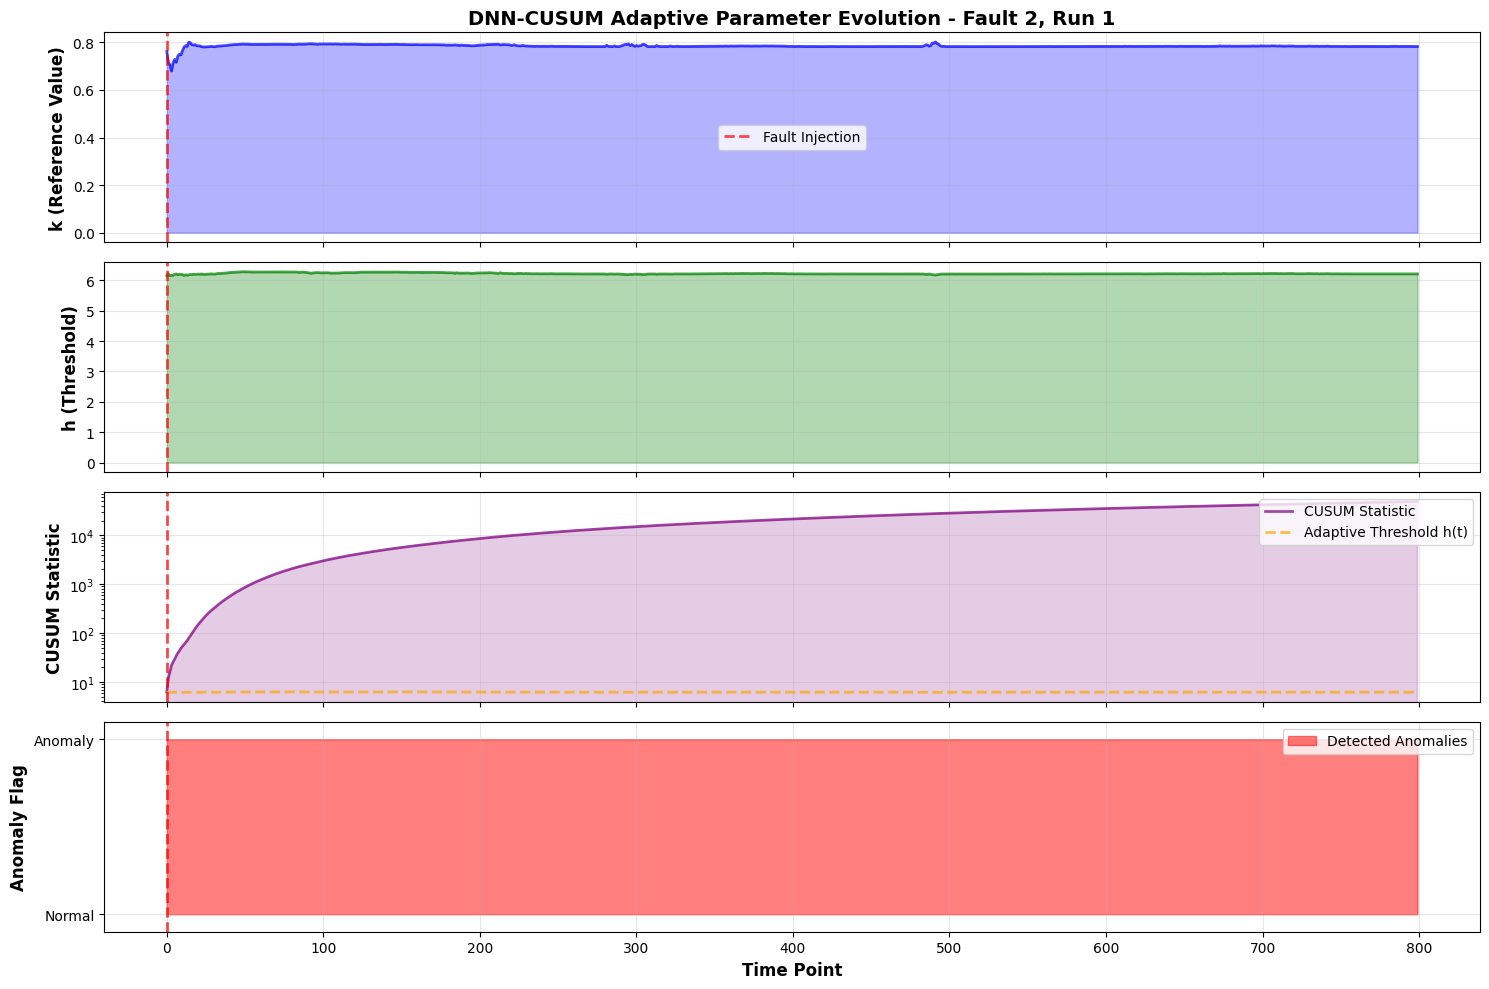

In [25]:
# Test DNN-CUSUM on fault data
print("\nTesting DNN-CUSUM on fault data...")
dnn_predictions, dnn_param_history = dnn_cusum.predict(
    X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT,
    return_params=True
)

# Calculate metrics
dnn_arl1 = np.argmax(dnn_predictions == 1) if np.any(dnn_predictions == 1) else None
dnn_detection_rate = np.mean(dnn_predictions) * 100

print(f"\nDNN-CUSUM Results:")
print(f"  Detection Delay (ARL1): {dnn_arl1}")
print(f"  Detection Rate: {dnn_detection_rate:.2f}%")

# Create visualizer
dnn_viz = DNNCUSUMVisualizer()

# Plot parameter evolution
print("\nGenerating parameter evolution plot...")
dnn_viz.plot_parameter_evolution(
    dnn_param_history,
    X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT,
    dnn_predictions,
    fault_injection_point=0,  # Already cut at fault injection
    title_suffix=f"- Fault {fault_number}, Run {simulation_run}"
)


Generating parameter statistics...


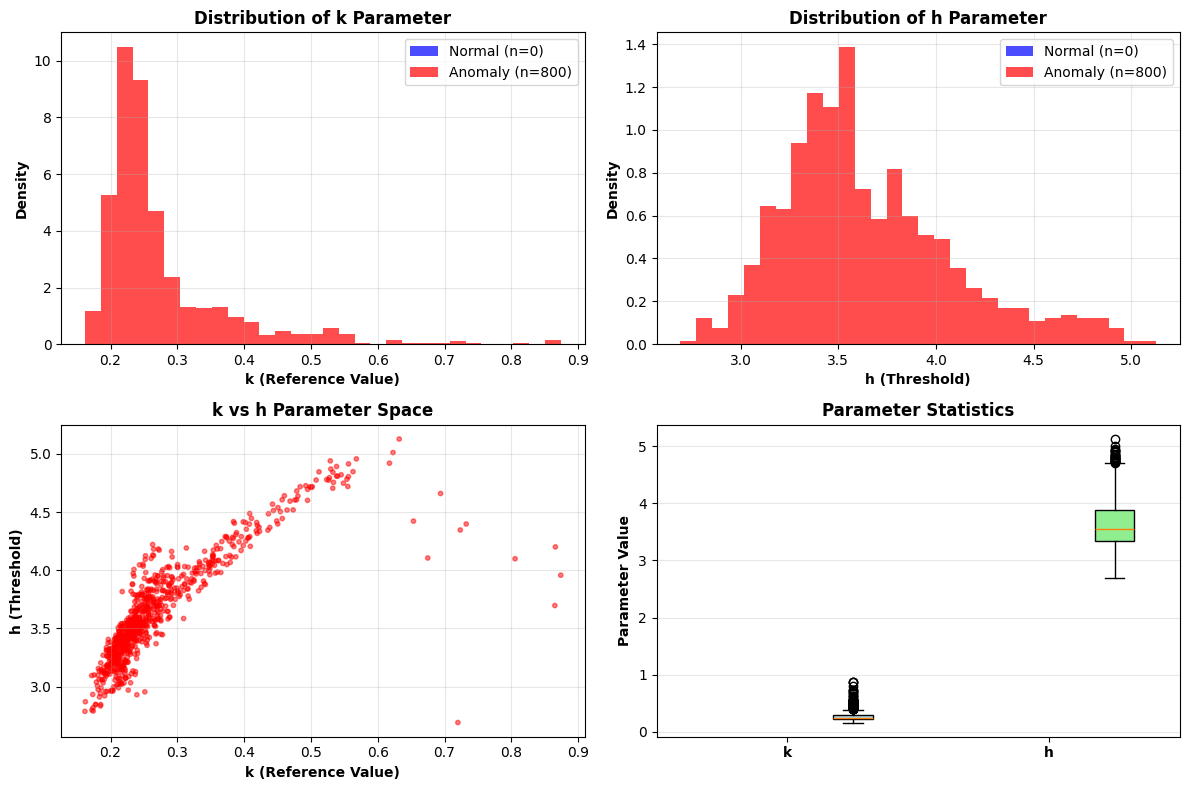

In [18]:
# Plot parameter statistics
print("Generating parameter statistics...")
dnn_viz.plot_parameter_statistics(dnn_param_history, dnn_predictions)


Comparing DNN-CUSUM with Fixed MCUSUM...
control limit h: 2.8620689655172415


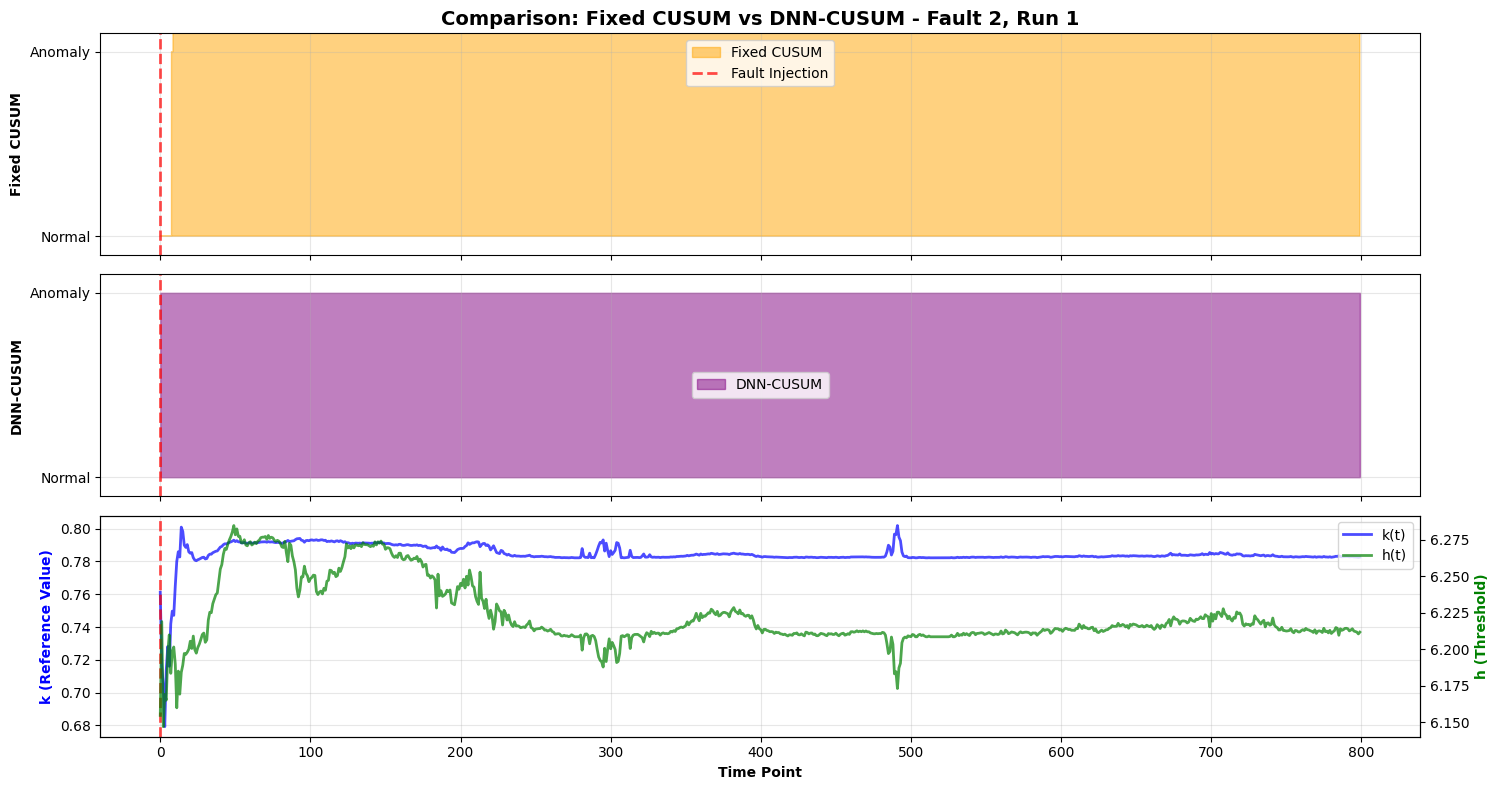


Detection Statistics Comparison

First Detection:
  Fixed CUSUM: 8
  DNN-CUSUM:   0
  Improvement: 8 samples (earlier)

Detection Rate:
  Fixed CUSUM: 1916243.13%
  DNN-CUSUM:   100.00%

Agreement: 0.12%



In [26]:
# Compare with fixed-parameter MCUSUM
print("Comparing DNN-CUSUM with Fixed MCUSUM...")

# Get fixed CUSUM predictions
fixed_mcusum_for_comparison = MCUSUMDetector(k=best_k, h=best_h)
fixed_mcusum_for_comparison.fit(X_INCONTROL_TRAIN_FULL_SCALED)
fixed_predictions, _ = fixed_mcusum_for_comparison.predict(X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT)

# Plot comparison
dnn_viz.plot_comparison(
    fixed_predictions.astype(int),
    dnn_predictions,
    X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT,
    param_history=dnn_param_history,
    fault_injection_point=0,
    title=f"- Fault {fault_number}, Run {simulation_run}"
)


Comparing DNN-CUSUM with Fixed MCUSUM on in-control data...
control limit h: 2.8620689655172415


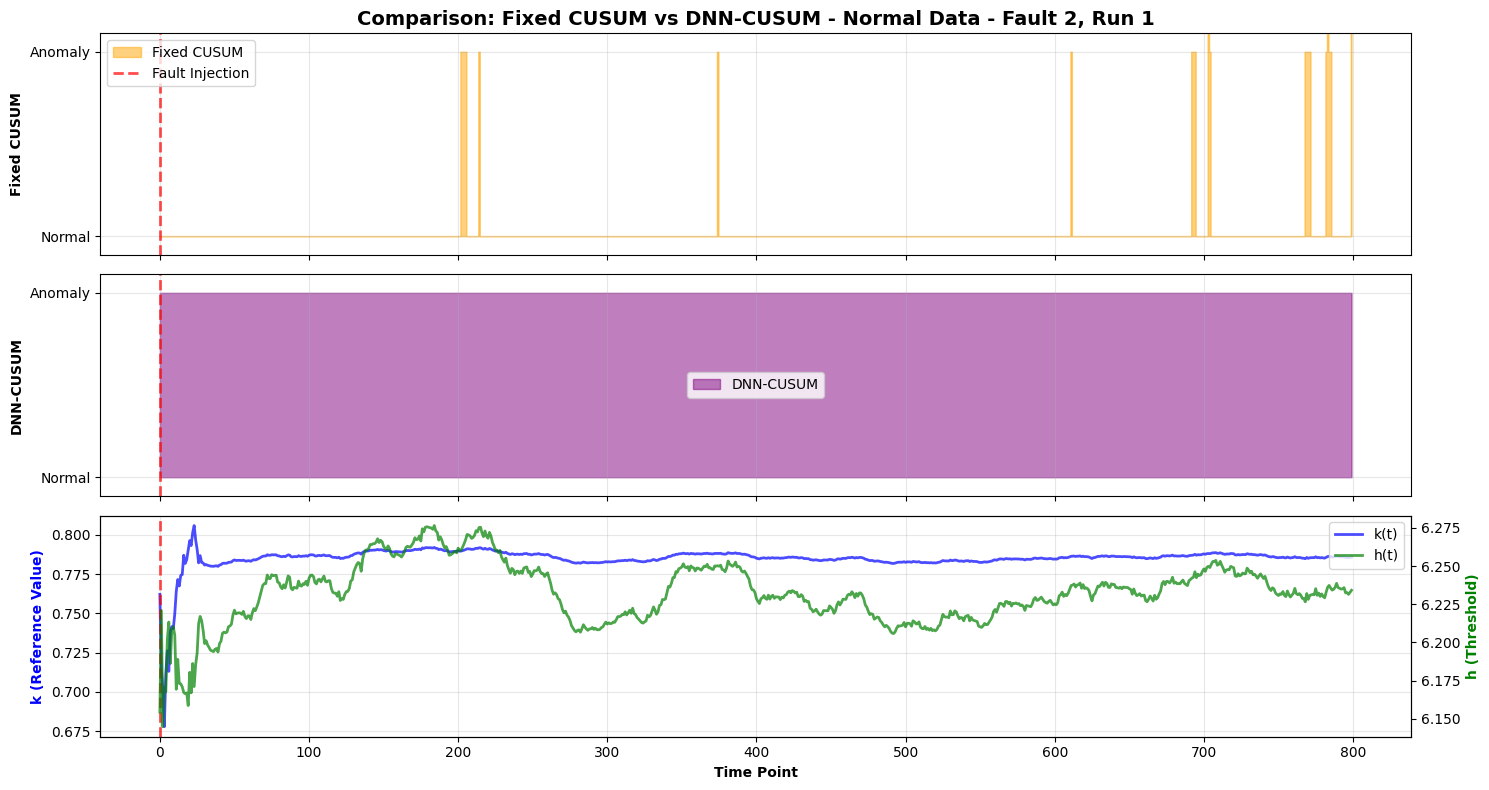


Detection Statistics Comparison

First Detection:
  Fixed CUSUM: 202
  DNN-CUSUM:   0
  Improvement: 202 samples (earlier)

Detection Rate:
  Fixed CUSUM: 3.00%
  DNN-CUSUM:   100.00%

Agreement: 2.25%



In [ ]:
# Compare with fixed-parameter MCUSUM on NORMAL data
print("Comparing DNN-CUSUM with Fixed MCUSUM on in-control data...")

# Fixed MCUSUM on normal data
fixed_mcusum_for_comparison = MCUSUMDetector(k=best_k, h=best_h)
fixed_mcusum_for_comparison.fit(X_INCONTROL_TRAIN_FULL_SCALED)
fixed_predictions, _ = fixed_mcusum_for_comparison.predict(X_INCONTROL_TEST_REDUCED_SCALED_CUT)

# DNN-CUSUM on SAME normal data (recompute!)
dnn_predictions_normal, dnn_param_history_normal = dnn_cusum.predict(
    X_INCONTROL_TEST_REDUCED_SCALED_CUT,  # ← Same as fixed MCUSUM
    return_params=True
)

# Plot comparison
dnn_viz.plot_comparison(
    fixed_predictions.astype(int),
    dnn_predictions_normal,  # ← Use NEW predictions on normal data
    X_INCONTROL_TEST_REDUCED_SCALED_CUT,
    param_history=dnn_param_history_normal,
    fault_injection_point=0,
    title=f"- Normal Data - Fault {fault_number}, Run {simulation_run}"
)


In [ ]:
# Plot 4: Threshold statistics (4 subplots)
print("Generating threshold statistics...")
deept_viz.plot_threshold_statistics(
    deept_threshold_history,
    deept_predictions,
    title_suffix=f"- Fault {fault_number}, Run {simulation_run}"
)

In [ ]:
# DeepT-CUSUM prediction wrapper for model comparison
def deept_cusum_predict(x_scaled):
    """
    Wrapper function for DeepT-CUSUM prediction to match the interface
    of other models in the comparison.
    
    Args:
        x_scaled: Scaled input data
    
    Returns:
        Binary predictions (0=normal, 1=anomaly)
    """
    preds, _ = deept_cusum.predict(x_scaled, return_thresholds=False)
    return preds.astype(int)

In [ ]:
# Plot 3: Comparison with Fixed CUSUM (4 subplots)
print("Comparing DeepT-CUSUM with Fixed MCUSUM...")

# Get fixed CUSUM predictions for comparison
fixed_mcusum_deept_comparison = MCUSUMDetector(k=best_k, h=best_h)
fixed_mcusum_deept_comparison.fit(X_INCONTROL_TRAIN_FULL_SCALED)
fixed_predictions_deept, _ = fixed_mcusum_deept_comparison.predict(X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT)

# Plot comparison
deept_viz.plot_comparison(
    fixed_predictions_deept.astype(int),
    deept_predictions,
    X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT,
    threshold_history=deept_threshold_history,
    fixed_h=best_h,
    title_suffix=f"- Fault {fault_number}, Run {simulation_run}"
)

In [ ]:
# Plot 2: Feedback analysis (4 subplots showing S_{t-1} vs h_t relationship)
print("Generating feedback analysis plot...")
deept_viz.plot_feedback_analysis(
    deept_threshold_history,
    deept_predictions,
    title_suffix=f"- Fault {fault_number}, Run {simulation_run}"
)

In [ ]:
# Test DeepT-CUSUM on fault data
print("\nTesting DeepT-CUSUM on fault data...")
deept_predictions, deept_threshold_history = deept_cusum.predict(
    X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT,
    return_thresholds=True
)

# Calculate metrics
deept_arl1 = np.argmax(deept_predictions == 1) if np.any(deept_predictions == 1) else None
deept_detection_rate = np.mean(deept_predictions) * 100

print(f"\nDeepT-CUSUM Results:")
print(f"  Detection Delay (ARL1): {deept_arl1}")
print(f"  Detection Rate: {deept_detection_rate:.2f}%")
print(f"  Fixed k: {best_k:.4f}")
print(f"  Adaptive h_t range: [{np.min(deept_threshold_history['h_t']):.2f}, {np.max(deept_threshold_history['h_t']):.2f}]")

# Create visualizer
deept_viz = DeepTCUSUMVisualizer()

# Plot 1: Threshold evolution (4 subplots)
print("\nGenerating threshold evolution plot...")
deept_viz.plot_threshold_evolution(
    deept_threshold_history,
    X_OUT_OF_CONTROL_TEST_REDUCED_SCALED_CUT,
    deept_predictions,
    fixed_h=best_h,  # Show comparison with fixed h
    fault_injection_point=0,
    title_suffix=f"- Fault {fault_number}, Run {simulation_run}"
)

In [ ]:
# Initialize DeepT-CUSUM detector with fixed k from grid search
print("Initializing DeepT-CUSUM detector...")
print(f"Using fixed k = {best_k:.4f} (from MCUSUM grid search)")

deept_cusum = DeepTCUSUMDetector(
    k_fixed=best_k,  # Use the optimal k from MCUSUM grid search
    model_dir='models/'
)

# Train DeepT-CUSUM (or load if already trained)
deept_cusum.fit(
    X_INCONTROL_TRAIN_FULL_SCALED,  # Use full dataset for fair comparison
    X_OUT_OF_CONTROL_TRAIN_REDUCED_SCALED,
    force_retrain=False,
    grid_search=True
)

print("\n" + "="*60)
print("DeepT-CUSUM training complete!")
print("="*60)

In [ ]:
# Import DeepT-CUSUM detector and visualizer
import importlib
import src.deept_cusum
import src.deept_cusum_viz

# Reload modules
importlib.reload(src.deept_cusum)
importlib.reload(src.deept_cusum_viz)

# Import the classes
from src.deept_cusum import DeepTCUSUMDetector
from src.deept_cusum_viz import DeepTCUSUMVisualizer

print("✓ DeepT-CUSUM modules loaded")

## DeepT-CUSUM (Deep Threshold CUSUM)

## Run with all samples

In [ ]:
import numpy as np

def get_first_false_alarm_index(flags_normal):
    if np.any(flags_normal == 1):
        return int(np.argmax(flags_normal == 1))
    return None

def get_first_detection_delay(flags_anomaly):
    if np.any(flags_anomaly == 1):
        return int(np.argmax(flags_anomaly == 1))
    return None

In [ ]:
# DNN-CUSUM prediction wrapper for model comparison
def dnn_cusum_predict(x_scaled):
    """
    Wrapper function for DNN-CUSUM prediction to match the interface
    of other models in the comparison.
    
    Args:
        x_scaled: Scaled input data
    
    Returns:
        Binary predictions (0=normal, 1=anomaly)
    """
    preds, _ = dnn_cusum.predict(x_scaled, return_params=False)
    return preds.astype(int)


In [ ]:

SIMULATION_RUN_RANGE = range(1, 21)
FAULT_NUMBER_RANGE = range(1, 21)

results: List[Dict[str, Any]] = []

# Add to MODELS dictionary

# Dictionary of models for extensibility
MODELS = {
    "MCUSUM": mcusum_predict,
    # "Autoencoder": autoencoder_detector.predict,
    # "AutoencoderEnhanced": autoencoder_detector_enhanced.predict,
    # "MEWMA": mewma.predict,
    "DNN_CUSUM": dnn_cusum_predict,  # Adaptive CUSUM with DNN parameter selection (both k and h)
    "DeepT_CUSUM": deept_cusum_predict  # Adaptive threshold CUSUM (fixed k, adaptive h with feedback)
}

for simulation_run in SIMULATION_RUN_RANGE:
    # In-control data
    DF_FF_TEST_SEQUENCED = DF_FF_TEST_RAW.query("simulationRun == @simulation_run")
    X_INCONTROL_TEST_DF = DF_FF_TEST_SEQUENCED.drop(columns=COLUMNS_TO_REMOVE, axis=1)
    X_INCONTROL_TEST_SCALED = scaler_incontrol.transform(X_INCONTROL_TEST_DF)[fault_injection_point:]

    # DF_FF_TRAINING_SEQUENCED = DF_FF_TRAINING_RAW.query("simulationRun == @simulation_run")
    # X_INCONTROL_TRAIN_DF = DF_FF_TRAINING_SEQUENCED.drop(columns=COLUMNS_TO_REMOVE, axis=1)
    # scaler_incontrol.fit(X_INCONTROL_TRAIN_DF)
    # X_INCONTROL_TRAIN_SCALED = scaler_incontrol.transform(X_INCONTROL_TRAIN_DF)[fault_injection_point:]
    
    # Precompute in-control predictions once per simulation run
    pred_normal_dict = {}
    for model_name, model_func in MODELS.items():
        pred_normal_dict[model_name] = model_func(X_INCONTROL_TEST_SCALED)

    for fault_number in FAULT_NUMBER_RANGE:
        # DF_F_TRAINING_SEQUENCED = DF_F_TRAINING_RAW.query("faultNumber == @fault_number and simulationRun == @simulation_run")
        # X_OUT_OF_CONTROL_TRAIN_DF = DF_F_TRAINING_SEQUENCED.drop(columns=COLUMNS_TO_REMOVE, axis=1)
        # X_OUT_OF_CONTROL_TRAIN_SCALED = scaler_incontrol.transform(X_OUT_OF_CONTROL_TRAIN_DF)[fault_injection_point:]

        # Out-of-control data
        DF_F_TEST_SEQUENCED = DF_F_TEST_RAW.query( "faultNumber == @fault_number and simulationRun == @simulation_run")
        X_OUT_OF_CONTROL_TEST_DF = DF_F_TEST_SEQUENCED.drop(columns=COLUMNS_TO_REMOVE, axis=1)
        X_OUT_OF_CONTROL_TEST_SCALED = scaler_incontrol.transform(X_OUT_OF_CONTROL_TEST_DF)[fault_injection_point:]
 
        # Run all models
        for model_name, model_func in MODELS.items():
            print(f"**Simulation Run: {simulation_run}, Fault Number: {fault_number}, Model: {model_name}**")
            pred_anomaly = model_func(X_OUT_OF_CONTROL_TEST_SCALED)
            pred_normal = pred_normal_dict[model_name]
            arl1 = get_first_detection_delay(pred_anomaly)
            arl0 = get_first_false_alarm_index(pred_normal)
            print(f"ARL0 (False Alarm): {arl0} ARL1 (Detection Delay): {arl1}")
            print()
            detection_fraction = np.mean(pred_anomaly)
            results.append({
                "simulationRun": simulation_run,
                "faultNumber": fault_number,
                "model": model_name,
                "ARL0": arl0,
                "ARL1": arl1,
                "detection_fraction": detection_fraction
            })

# Convert results to DataFrame and aggregate metrics (unchanged)
df_results = pd.DataFrame(results)

grouped = df_results.groupby(['model', 'faultNumber'])
conditional_arl0 = grouped['ARL0'].apply(lambda x: x.dropna().mean() if not x.dropna().empty else np.nan)
sdrl0 = grouped['ARL0'].apply(lambda x: x.dropna().std() if len(x.dropna()) > 1 else np.nan)
non_fa_fraction = grouped['ARL0'].apply(lambda x: x.isnull().mean())
conditional_arl1 = grouped['ARL1'].apply(lambda x: x.dropna().mean() if not x.dropna().empty else np.nan)
sdrl1 = grouped['ARL1'].apply(lambda x: x.dropna().std() if len(x.dropna()) > 1 else np.nan)
non_detection_fraction = grouped['ARL1'].apply(lambda x: x.isnull().mean())
avg_detection_fraction = grouped['detection_fraction'].mean()

summary_df = pd.DataFrame({
    'conditional_ARL0': conditional_arl0,
    'SDRL0': sdrl0,
    'non_FA_fraction': non_fa_fraction,
    'conditional_ARL1': conditional_arl1,
    'SDRL1': sdrl1,
    'non_detection_fraction': non_detection_fraction,
    'avg_detection_fraction': avg_detection_fraction
}).reset_index()


In [ ]:
from src.ModelComparisonAnalyzer import ModelComparisonAnalyzer
# Usage example:
def analyze_results(df_results: pd.DataFrame, summary_df: pd.DataFrame):
    """
    Main function to run the complete analysis.
    
    Args:
        df_results: Your results DataFrame
        summary_df: Your summary DataFrame
    """
    # Initialize analyzer
    analyzer = ModelComparisonAnalyzer(df_results, summary_df)
    
    # Generate full report
    summary_stats, comparison_table = analyzer.generate_full_report()
    
    # Generate fault-specific analysis for selected faults
    for fault in [1, 5, 10, 15, 20]:  # Analyze specific faults
        if fault in analyzer.fault_numbers:
            fig = analyzer.plot_fault_specific_comparison(fault)
            plt.show()
    
    # Return analyzer for further custom analysis if needed
    return analyzer

# After your main loop, use it like this:
analyzer = analyze_results(df_results, summary_df)